In [1]:
# autoreload
%load_ext autoreload
%autoreload 2


In [2]:
from utils.pianoroll import PianoRoll
import matplotlib.pyplot as plt
import numpy as np

In [167]:
pr = PianoRoll.from_midi('../../log/ema_0.9999_2700000/6.mid')

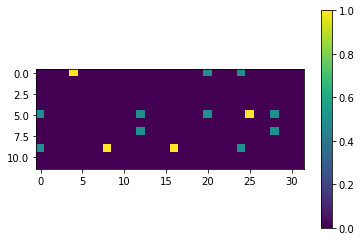

In [168]:
ch = (pr.to_tensor(chromagram=True)>0).float()
ch /= (ch.sum(dim=1, keepdim=True)+1e-9)
plt.imshow(ch[:32].t())
plt.colorbar()

In [169]:
def sim_mat(x):
    return x @ x.t() 
s = sim_mat(ch)

In [170]:
def harmonic_mean(x):
    return 1/(1/(x)).mean(dim=1)
fitness = s.mean(dim=1)

tensor(0., dtype=torch.float64) tensor(6.3115, dtype=torch.float64)


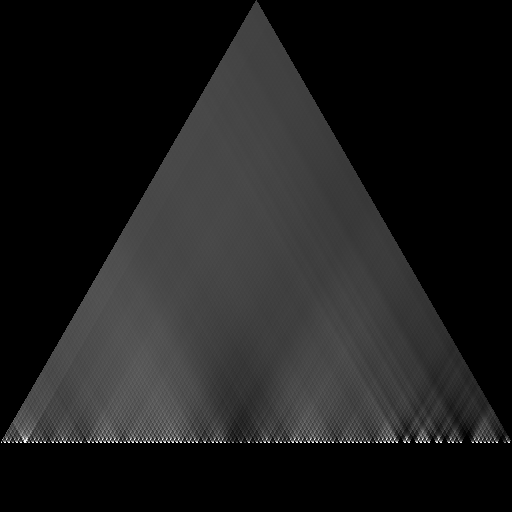

In [171]:
n = len(fitness)
scape = np.zeros((n, n))
scape[0] = fitness**0.5
for l in range(n):
    for m in range(n-l):
        scape[l, m] = scape[l-1, m] + fitness[m+l]**0.5
for l in range(n):
    scape[l] = (scape[l]/(l+1))**2

import io
import PIL.Image
import torchvision.transforms.functional as TF
import torch
def fig_to_pil(fig):
    plt.axis('off')
    fig.axes[0].get_xaxis().set_visible(False)
    fig.axes[0].get_yaxis().set_visible(False)
    buf = io.BytesIO()
    
    fig.savefig(buf,pad_inches =0)
    buf.seek(0)
    return PIL.Image.open(buf)

#(1.23205 | -1.23205 | 1.73205 -0.366025 | -1.36603 | 1.36603)
scape = TF.to_tensor(scape)/0.009
print(scape.min(), scape.max())
scape = torch.cat([scape,scape,scape])
img = TF.to_pil_image((scape).clamp(0,1))
img.transform(img.size,PIL.Image.AFFINE,[1,-0.5,0,0,1,0]).transform(img.size,PIL.Image.AFFINE,[1,0,0,0,-2/3**0.5,img.size[1]])


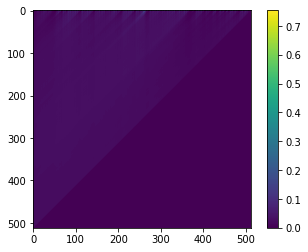

In [164]:
plt.imshow(scape[0])
plt.colorbar()

In [72]:

fitness

tensor([1.1797e-09, 1.0000e-09, 1.0000e-09, 1.0000e-09, 1.3196e-09, 1.0000e-09,
        1.0000e-09, 1.0000e-09, 1.1852e-09, 1.0000e-09, 1.0000e-09, 1.0000e-09,
        1.1082e-09, 1.0000e-09, 1.1558e-09, 1.0000e-09, 1.0579e-09, 1.0000e-09,
        1.2488e-09, 1.0000e-09, 1.0579e-09, 1.0000e-09, 1.0579e-09, 1.0000e-09,
        1.0000e-09, 1.0000e-09, 1.0000e-09, 1.0000e-09, 1.1690e-09, 1.0000e-09,
        1.0000e-09, 1.0000e-09, 1.2367e-09, 1.0000e-09, 1.0000e-09, 1.0000e-09,
        1.2133e-09, 1.0000e-09, 1.2367e-09, 1.0000e-09, 1.1558e-09, 1.0000e-09,
        1.3230e-09, 1.0000e-09, 1.1797e-09, 1.0000e-09, 1.1879e-09, 1.0000e-09,
        1.1082e-09, 1.0000e-09, 1.0847e-09, 1.0000e-09, 1.2488e-09, 1.0000e-09,
        1.2427e-09, 1.0000e-09, 1.2488e-09, 1.0000e-09, 1.2488e-09, 1.0000e-09,
        1.2488e-09, 1.0000e-09, 1.1558e-09, 1.0000e-09, 1.1852e-09, 1.0000e-09,
        1.0000e-09, 1.0000e-09, 1.0779e-09, 1.0000e-09, 1.1253e-09, 1.0000e-09,
        1.0579e-09, 1.0000e-09, 1.1253e-

Creating dataset segment_len = 0


  1%|          | 3/244 [00:00<00:08, 28.28it/s]

Created dataset with 244 data points from 244 pieces


100%|██████████| 244/244 [00:09<00:00, 24.50it/s]


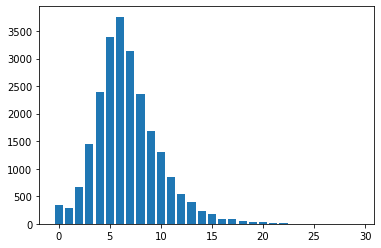

In [126]:
import torch
import matplotlib.pyplot as plt
from utils.pianoroll import PianoRoll, PianoRollDataset
from tqdm import tqdm
import numpy as np

velocity_mapping = lambda x: x**0.1

def calc_polyphony(pr:torch.Tensor,velocity_mapping = lambda x: (x<0.2)*4.5*x+(x>0.2)*(0.9+0.125*(x-0.2))):
    """Calculate the polyphony of a one-bar pianoroll.

    Args:
        pr (torch.Tensor): A pianoroll tensor with shape (B,32,88). Values are in [0,127].

    Returns:
        int: The polyphony of the pianoroll.
    """
    assert list(pr.shape)[-2:] == [32,88]
    B = pr.shape[0]
    pr = (pr/128).clamp(0,1)
    pr = velocity_mapping(pr) # [B,32,88]
    #pr = (pr>0).float()#===============================
    end_dist_list = []
    scanner = torch.zeros(B,88,device=pr.device)
    for i in range(31,-1,-1):
        scanner = scanner + 1
        end_dist_list += [scanner]
        current = pr[:,i]
        scanner = scanner * (1-current)

    end_dist = torch.stack(list(reversed(end_dist_list)),dim=1) # [B,32,88]
    weights = end_dist.detach()

    weighted_pr = pr * weights # [B,32,88]
    polyphony = weighted_pr.sum(dim=2).mean(dim=1) # [B]
    return polyphony

if __name__ == '__main__':
    #　Load the data
    ds = PianoRollDataset('/screamlab/home/eri24816/pianoroll_dataset/data/dataset_1/pianoroll_split/val')
    #　Calculate the polyphony
    bins = np.zeros(88)
    polyphony_list = []
    for pr in tqdm(ds.pianorolls):
        pr = pr.to_tensor()
        pr = pr.view(-1,32,88)
        for bar in pr:
            polyphony = calc_polyphony(bar.unsqueeze(0))
            bins[min(int(polyphony),139)]+=1
            polyphony_list.append(polyphony[0].item())

    plt.bar(range(30),bins[:30])
    plt.savefig('polyphony.png')


In [127]:
# get 11 quantiles
import numpy as np
quantiles = np.quantile(polyphony_list, np.arange(0,1.1,0.1))
str(list(quantiles))


'[0.0, 3.7857017517089844, 4.85215015411377, 5.589112281799317, 6.218849468231202, 6.821882247924805, 7.497886848449708, 8.337719917297363, 9.453008842468263, 11.174796867370604, 30.271657943725586]'

In [119]:
pr= torch.zeros(4,32,88)
pr[0,19,50] = 80
pr[0,0,50] = 80
pr[0,0,51] = 80
calc_polyphony(pr)

tensor([1.9260, 0.0000, 0.0000, 0.0000])

In [116]:
def calc_polyphony(pr:torch.Tensor,velocity_mapping = lambda x: x**0.1):
    """Calculate the polyphony of a one-bar pianoroll.

    Args:
        pr (torch.Tensor): A pianoroll tensor with shape (B,32,88). Values are in [0,127].

    Returns:
        int: The polyphony of the pianoroll.
    """
    assert list(pr.shape)[-2:] == [32,88]
    B = pr.shape[0]
    pr = (pr/128).clamp(0,1)
    pr = velocity_mapping(pr) # [B,32,88]
    #pr = (pr>0).float()#===============================
    end_dist_list = []
    scanner = torch.zeros(B,88,device=pr.device)
    for i in range(31,-1,-1):
        scanner = scanner + 1
        end_dist_list += [scanner]
        current = pr[:,i]
        scanner = scanner * (1-current)

    end_dist = torch.stack(list(reversed(end_dist_list)),dim=1) # [B,32,88]
    weights = end_dist.detach()

    weighted_pr = pr * weights # [B,32,88]
    polyphony = weighted_pr.sum(dim=2).mean(dim=1) # [B]
    return polyphony

In [14]:
def map_with_quantiles(x,quantiles):
    # map x with quantiles of its distribution to uniform [0,1]
    result = torch.zeros_like(x)
    n = len(quantiles)-1
    for i in range(n):
        result += (x>=quantiles[i])*(x<quantiles[i+1]) * (i/n + (x-quantiles[i])/(quantiles[i+1]-quantiles[i])/n)
    
    result += (x>=quantiles[n]) * (i/n + (x-quantiles[i])/(quantiles[i+1]-quantiles[i])/n)
    return result


In [15]:
mapped_polyphony_list = map_with_quantiles(torch.tensor(polyphony_list),quantiles)

<BarContainer object of 51 artists>

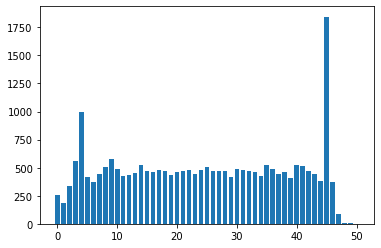

In [16]:
# histogram of mapped polyphony
bins = np.zeros(51)
for p in mapped_polyphony_list:
    bins[int(p*50)]+=1
plt.bar(range(51),bins)

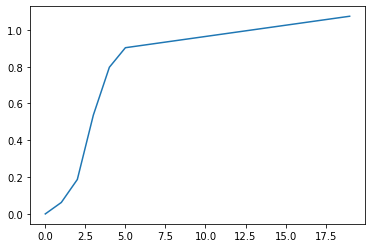

In [26]:
plt.plot(map_with_quantiles(torch.tensor(np.linspace(0,0.5,20)),quantiles))

In [35]:
def map_to_quantiles(x:float,quantiles):
    # map x with uniform [0,1] to quantiles of its distribution.
    # differentiable
    # quantiles includes 0 and 1
    n = len(quantiles)-1
    for i in range(n):
        if x < (i+1)/n:
            return quantiles[i] + (x-i/n)*(quantiles[i+1]-quantiles[i])
    return quantiles[n]

In [37]:
map_to_quantiles(1,quantiles)

0.34026625752449036

In [110]:
a = torch.tensor([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]).unsqueeze(1)
l=0
for i in a:
    l+=a.sum()
l.backward()
a.grad

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [111]:
i

tensor([1.])